【問題1】2次元畳み込み層の作成

In [1]:
class Conv_SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
    n_nodes1:
    n_nodes2:
    ガウス分布の標準偏差
    """
    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, out_channel, in_channel, filter_h, filter_w):
        """
        重みの初期化
        Parameters
        ----------
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(out_channel, in_channel, filter_h, filter_w)
        return W
    
    
    def B(self, out_channel):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
        後の層のノード数
        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(out_channel)[np.newaxis, :]
        
        return B

In [2]:
class FC_SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
    n_nodes1:
    n_nodes2:
    ガウス分布の標準偏差
    """
    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, filter_h, filter_w):
        """
        重みの初期化
        Parameters
        ----------
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(filter_h, filter_w)
        return W
    
    
    def B(self, out_channel):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
        後の層のノード数
        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(out_channel)[np.newaxis, :]
        
        return B

In [3]:
class Xavier:
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, out_channel, in_channel, filter_h, filter_w):
        W_xavi = self.sigma * np.random.randn(out_channel, in_channel, filter_h, filter_w)/np.sqrt(in_channel)
        
        return W_xavi
    
    def B(self, out_channel):
        B = self.sigma * np.random.randn (out_channel)[np.newaxis, :]
    
        return B

In [4]:
class He:
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, out_channel,in_channel, filter_h, filter_w):
        W_he = self.sigma * np.random.randn(out_channel, in_channel, filter_h, filter_w)/np.sqrt(in_channel)*np.sqrt(2)
        
        return W_he
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn (out_channel)[np.newaxis, :]
        
        return B

In [5]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        
        return layer

In [6]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr
        self.h = 1e-7
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        self.h += layer.dW*layer.dW
        layer.W -= self.lr*layer.dW/np.sqrt(self.h)
        layer.B -= self.lr * layer.dB
        
        return layer

In [7]:
class Sigmoid:
    """
    sigmoid関数の処理と導関数の算出
    """
    
    def __init__(self):
        pass
        
    def forward(self, A):
        self.A  = A
        Z = 1/(1+np.exp(-self.A))
        
        return Z
    
    def backward(self, dout):
        Z = self.forward(self.A)
        dout_sig = Z*(1-Z)*dout
        
        return dout_sig
    
class Tanh:
    """
    tanh関数の処理と導関数の算出
    """
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        Z = (np.exp(self.A)-np.exp(-self.A)) / (np.exp(self.A)+np.exp(-self.A))
        
        return Z
    
    def backward(self, dout):
        Z = self.forward(self.A)
        dout_tanh = (1-Z**2)*dout
        
        return dout_tanh
    
class Relu:
    """
    relu関数の処理と導関数の算出
    """
    
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        Z = np.where(self.A<=0, 0, self.A)
        
        return Z
    
    def backward(self, dout):
        dout_relu = np.where(self.A<=0, 0, 1)*dout
        
        return dout_relu
    
class Softmax:
    """
    relu関数の処理とsoftmax_with_cross_entropyの導関数の算出
    """
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        #if A.ndim == 2:
           # A = A.T
           # A = A - np.max(A, axis=0)
           # y = np.exp(A) / np.sum(np.exp(A), axis=0)
           # return y.T
        A = A - np.max(A)
        Z = np.exp(A) / np.sum(np.exp(A) ,axis=1, keepdims=True)
        self.Z = Z
        
        return Z
    
    
    def backward(self, y):
        dout_soft_max = self.Z - y
        
        return dout_soft_max

In [8]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
    

In [9]:
class Dropout:
    """
    randomに生成したWと同じ配列の要素でdroput_ratioを以下のものをFalseとして格納
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, X, train_flag=True):
        if train_flag:
            self.mask = np.random.rand(*X.shape) > self.dropout_ratio # *X.shapeはXと同じshapeにするため
            return X*self.mask
        
        else:
            return X*(1-self.dropout_ratio)
        
    def backward(self, dout):
        
        return dout * self.mask

In [10]:
class Loss:
    
    def __init__(self):
        pass
        
    def cross_entropy_error(self, y_pred, y):
        cross_entropy_error = np.sum(-1*y*np.log(y_pred+1e-10),axis=1)
        
        return cross_entropy_error

In [11]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        # CNNからの入力を1次元配列にする
            
        # XとWの内積をとり、biasを加える
        self.Z = copy.deepcopy(X) # Xが更新されないように
        A = np.dot(X, self.W) + self.B
        #print('A.shape{}'.format(A.shape))
        
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 勾配を算出する
        self.dB = np.average(dA)
        self.dW = np.dot(self.Z.T, dA)
        
        dZ = np.dot(dA, self.W.T)
        
        self = self.optimizer.update(self)# FCクラスのself.W, self.B, self.dW, self.dBを用いて更新
        
        # print('FC dZ{}'.format(dZ.shape))
        
        return dZ

In [12]:
class ScratchDeepNeuralNetrowkClassifier:
    """
    FCでインスタンスを作り、Activationで活性化関数を通したものをaddで追加指定いく
    """
    def __init__(self, epoch, batch_size):
        self.epoch = epoch
        self.batch_size = batch_size
        self.losses = []
        self.val_losses=[]
        self.layers = []
        
    def add(self, layer):
        self.layers += [layer] # model.add(インスタンスで層を追加)
    
    def forward_layer(self, X):
        for layer in self.layers:
            X = layer.forward(X)
            
        return X
    
    def backward_layer(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)
            
        return y
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        count = 1
        mini_losses = []
        for i in range(self.epoch):
            print('-----------------')
            print('epoch{}回目の学習'.format(i+1))
            get_mini_batch = GetMiniBatch(X, y, self.batch_size, seed=10)
            #if X_val is not None and y_val is not None:
            
            # minibatchのイテレーション
            for mini_X_train, mini_y_train in get_mini_batch:
                #イテレーションごとのフォワード
                Z3 = self.forward_layer(mini_X_train)
                mini_loss = Loss()
                mini_train_loss = np.sum(mini_loss.cross_entropy_error(Z3, mini_y_train))/len(mini_y_train)
                if count % 10 == 0:
                    print('ミニバッチ{}回目'.format(count))
                    mini_losses += [mini_train_loss]
                    print('mini_train_loss{}'.format(mini_train_loss))
                    
                #イテレーションごとのバックワード
                dX = self.backward_layer(mini_y_train)# 使わない
                count += 1
                
            loss = Loss()
            Z3_train = self.forward_layer(X_train)
            epoch_train_loss = np.sum(loss.cross_entropy_error(Z3_train, y_train))/len(y_train) # 最後の重みでエポックlossを算出
            self.losses += [epoch_train_loss]
            print('epoch_train_loss{}'.format(epoch_train_loss))
            
            if np.any(X_val):
                val_loss = Loss()
                Z3_val = self.forward_layer(X_val)
                epoch_val_loss = np.sum(loss.cross_entropy_error(Z3_val, y_val))/len(y_val) # val_lossもtrain
                self.val_losses += [epoch_val_loss] 
                print(('epoch_val_loss{}'.format(epoch_val_loss)))
                
                
    def predict(self, X_test):
        X = X_test
        for layer in self.layers:
            X = layer.forward(X)
        
        y_pred = np.argmax(X, axis=1)
        
        return y_pred
    
    def accuracy(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = np.sum(y_pred==y_test)/len(y_test)
        
        return accuracy


In [13]:
import numpy as np
from keras.datasets import mnist
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [14]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [15]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [16]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 28,28)
print(X_val.shape) # (12000, 28,28)

(48000, 1, 28, 28)
(12000, 1, 28, 28)


【問題2】2次元畳み込み後の出力サイズ

In [18]:
class Scratch2dCNNClassifier:
    """
    2次元の畳み込み
    Parameters
    ----------
    filter_size : int
      フィルターの大きさ=Wの要素数
    initializer : 重みの初期値の決定
    初期化方法のインスタンス
    optimizer : 最適化手法を選択
    最適化手法のインスタンス
    """
    
    def __init__(self, in_channel, out_channel, filter_h, filter_w, initializer, optimizer, pad=0, h_stride=1, w_stride=1):
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.filter_h = filter_h
        self.filter_w = filter_w
        self.initializer = initializer
        self.optimizer = optimizer
        self.pad = pad
        self.h_stride = h_stride
        self.w_stride = w_stride
        
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.sample_size = 0
        self.W = self.initializer.W(self.out_channel, self.in_channel, self.filter_h, self.filter_w)
        self.B = self.initializer.B(out_channel)
        self.A = 0
        self.Z = 0
        self.dW = np.zeros_like(self.W)
        self.dB = np.zeros_like(self.B)
        
    def calculate_out_put_size(self, in_h, in_w):
        """
        outputのheightとwidthを計算する
        """
        out_h = 1 + (in_h + 2*self.pad - self.filter_h)//self.h_stride
        out_w = 1 + (in_w + 2*self.pad - self.filter_w)//self.w_stride
        
        return out_h, out_w
    
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, in_channel, in_h, in_w)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_samples, out_channel, out_h, out_w)
            出力
        """
        
        self.Z = copy.deepcopy(X)
        self.batch_size = len(X)
        in_h = X.shape[2]
        in_w = X.shape[3]
        
        out_h, out_w = self.calculate_out_put_size(in_h, in_w)
        
        A = np.zeros([self.batch_size, self.out_channel, out_h, out_w])
        
        # sample方向、channel方向、out_channelの方向、height方向、width方向にループを回す
        for n in range(self.batch_size):
            for k in range(X.shape[1]):
                for m in range(self.out_channel):
                    for i in range(out_h):
                        for j in range(out_w):
                            if j+self.filter_w > X.shape[3]:# heightのはみ出した部分の削除
                                continue
                            elif i+self.filter_h > X.shape[2]:#幅のはみ出した部分の削除
                                continue

                            A[n, m, i, j] = (np.sum(X[n, k, i:i+self.filter_h, j:j+self.filter_w]*self.W[m, k]) + self.B[0,m]).reshape(-1)
        
        self.A = A
        #print('2dconvA.shape{}'.format(A.shape))
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, out_channel, out_h, out_w)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, channel, in_h, in_w)
            前に流す勾配
        """
        # dWの算出
        # sample方向、channel方向、out_channelの方向、height方向、width方向にループを回す
        for n in range(self.batch_size):
            for k in range(self.Z.shape[1]):
                for m in range(self.out_channel):
                    for i in range(dA.shape[2]):
                        for j in range(dA.shape[3]):
                            for s in range(self.filter_h):
                                for t in range(self.filter_w):
                                    self.dW[m, k, s, t] += (dA[n, m, i, j]*self.Z[n, k, i+s, j+t]).reshape(-1)
                                    
        
        # dBの算出
        for m in range(dA.shape[1]):
            self.dB[0, m] = np.sum(dA[:,m,:,:]).reshape(-1)
            
        # dZの算出
        dZ = np.zeros_like(self.Z)
        for n in range(self.batch_size):
            for k in range(self.Z.shape[1]):
                for m in range(dA.shape[1]):
                    for i in range(dA.shape[2]):
                        for j in range(dA.shape[3]):
                            for s in range(self.filter_h):
                                for t in range(self.filter_w):
                                    
                                    # jとt(in_w方向)の条件
                                    if (j-t)/self.w_stride < 0:
                                        continue
                                    elif (j-t)/self.w_stride > dA.shape[3]-1:
                                        continue
                                    elif (j-t)%self.w_stride !=0:#strideの定数倍のみ残す
                                        continue
                                        
                                    #  iとs(in_h)の条件
                                    elif (i-s)/self.h_stride < 0:
                                        continue
                                    elif (i-s)/self.h_stride > dA.shape[2]-1:
                                        continue
                                    elif (i-s) % self.h_stride != 0:#strideの定数倍のみ残す
                                        continue
                                            
                                    dZ[n, k, i, j] += dA[n, m, i-s, j-t] * self.W[m, k, s, t]
        self = self.optimizer.update(self)# 2dCNNクラスのself.W, self.B, self.dW, self.dBを用いて更新
        
        #print('2d_conv_dA{}'.format(dA))
        
        return dZ

【問題3】最大プーリング層の作成

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

In [19]:
class MaxPool2D:
    """
    i行j列への出力する場合の入力配列から最大値のインデックスを取得
    """
    def __init__(self, pool_h=2, pool_w=2, pool_h_stride=2, pool_w_stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.h_stride = pool_h_stride
        self.w_stride = pool_w_stride
        self.pad = pad
        
        self.masks = 0
        
    
    def calculate_out_put_size(self, in_h, in_w):
        """
        outputのheightとwidthを計算する
        """
        out_h = 1 + (in_h + 2*self.pad - self.pool_h)//self.h_stride
        out_w = 1 + (in_w + 2*self.pad - self.pool_w)//self.w_stride
        
        return out_h, out_w
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, in_channel, in_h, in_w)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_samples, in_channel, out_h, out_w)
            出力
        """
        self.Z = copy.deepcopy(X)
        in_channel = X.shape[1]
       
        in_h = X.shape[2]
        in_w = X.shape[3]
        out_h, out_w = self.calculate_out_put_size(in_h, in_w)
        A = np.zeros([len(X), in_channel, out_h, out_w])
        self.mask = np.zeros_like(X)
        
        for n in range(len(X)):
            for k in range(in_channel):
                for i in range(out_h):
                    for j in range(out_w):
                        A[n,k,i,j] = np.max(X[n, k, i:i+self.pool_h, j:j+self.pool_w])
                        self.mask[n, k, i:i+self.pool_h, j:j+self.pool_w] += (X[n, k, i:i+self.pool_h, j:j+self.pool_w] == A[n,k,i,j]).astype(int)
        
        self.mask = np.where(self.mask>1, 1, self.mask)
        return A
        
    def backward(self,dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, channel, out_h, out_w)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, channel, in_h, in_w)
            前に流す勾配
        """
        dZ = np.zeros_like(self.Z)
        for n in range(len(dA)):
            for m in range(dA.shape[1]):
                for i in range(dA.shape[2]):
                    for j in range(dA.shape[3]):
                        dZ[n,m,i:i+self.pool_h, j:j+self.pool_w] = self.mask[n,m,i:i+self.pool_h, j:j+self.pool_w] * dA[n,m,i,j]
                        
        return dZ

pooling forward

In [20]:
# maskの挙動を確認
import numpy as np
a = np.arange(64)
a[5] = 20
a[13] = 40
a[34] = 90
a = a.reshape(2,2,4,4)
z = np.zeros([2,2,3,3])
mask = np.zeros_like(a)
for n in range(len(a)):
    for k in range(a.shape[1]):
        for i in range(3):
            for j in range(3):
                z[n,k,i,j] = np.max(a[n, k, i:i+2, j:j+2])
                mask[n, k, i:i+2, j:j+2] += (a[n, k, i:i+2, j:j+2] == z[n,k,i,j]).astype(int)
                
mask = np.where(mask>1, 1, mask)


【問題4】平滑化

In [21]:
class Flatten():
    """
    forwardで4次元配列を2次元にする
    backwardで元の配列を4次元に戻す
    """
    def __init__(self):
        self.Z = 0
    
    def forward(self, X):
        """
        forward:
        入力X:次の形のndarray, (n_samples, channel, h, w)
        
        -------------------------
        出力A:次の形のndarray, (n_samples, n_features)
        """
        
        self.Z = copy.deepcopy(X)
        A = X.reshape(len(X), -1)
        
        #print('Flatten A.shape{}'.format(A.shape))
        return A
    
    def backward(self, dA):
        """
        backward:
        入力dA:次の形のndarray, (n_samples, n_features)
        
        -------------------------
        出力dZ:次の形のndarray, (n_samples, cannel, h, w)
        """
        dZ = dA.reshape(self.Z.shape)
        #print('Flatten dZshape{}'.format(dZ.shape))
        
        return dZ
        

In [22]:
two_d_cnn = ScratchDeepNeuralNetrowkClassifier(5, 10)
two_d_cnn.add(Scratch2dCNNClassifier(1, 1, 5, 5, Conv_SimpleInitializer(sigma=0.01), AdaGrad(0.01)))
two_d_cnn.add(Dropout(0.2))
two_d_cnn.add(MaxPool2D(1,1))
two_d_cnn.add(Tanh())
#two_d_cnn.add(Scratch2dCNNClassifier(1, 1, 5, 5, Conv_SimpleInitializer(sigma=0.1), AdaGrad(0.01)))
#two_d_cnn.add(Dropout(0.2))
#two_d_cnn.add(MaxPool2D(1,1))
#two_d_cnn.add(Tanh())
two_d_cnn.add(Flatten())
two_d_cnn.add(FC(144, 100, FC_SimpleInitializer(sigma=0.01), AdaGrad(0.01)))
two_d_cnn.add(Dropout(0.2))
two_d_cnn.add(Tanh())
two_d_cnn.add(FC(100, 50, FC_SimpleInitializer(sigma=0.01), AdaGrad(0.01)))
two_d_cnn.add(Dropout(0.2))
two_d_cnn.add(Tanh())
two_d_cnn.add(FC(50, 10, FC_SimpleInitializer(sigma=0.01), AdaGrad(0.01)))
two_d_cnn.add(Softmax())

two_d_cnn.fit(X_train, y_train, X_val, y_val)

-----------------
epoch1回目の学習
ミニバッチ10回目
mini_train_loss2.29197586980256
ミニバッチ20回目
mini_train_loss2.19561190940425
ミニバッチ30回目
mini_train_loss2.0608749468617895
ミニバッチ40回目
mini_train_loss1.837969744335129
ミニバッチ50回目
mini_train_loss1.6988728203843582
ミニバッチ60回目
mini_train_loss1.9948238864710965
ミニバッチ70回目
mini_train_loss1.8645305836415766
ミニバッチ80回目
mini_train_loss2.0638277878986395
ミニバッチ90回目
mini_train_loss1.597691551408052
ミニバッチ100回目
mini_train_loss1.861102149095922
ミニバッチ110回目
mini_train_loss2.050396355388187
ミニバッチ120回目
mini_train_loss1.4927761076547266
ミニバッチ130回目
mini_train_loss1.4082623769028173
ミニバッチ140回目
mini_train_loss1.6263581741659792
ミニバッチ150回目
mini_train_loss1.2545222911149252
ミニバッチ160回目
mini_train_loss1.916915972453534
ミニバッチ170回目
mini_train_loss1.6529697584713365
ミニバッチ180回目
mini_train_loss1.443738312804899
ミニバッチ190回目
mini_train_loss1.4584786860847652
ミニバッチ200回目
mini_train_loss1.9060392959460206
ミニバッチ210回目
mini_train_loss1.3962030765689817
ミニバッチ220回目
mini_train_loss2.0721964094889667

ミニバッチ1820回目
mini_train_loss1.528619043776832
ミニバッチ1830回目
mini_train_loss0.6490581370921278
ミニバッチ1840回目
mini_train_loss0.9853456638319544
ミニバッチ1850回目
mini_train_loss1.4092748276711744
ミニバッチ1860回目
mini_train_loss1.1868672294915734
ミニバッチ1870回目
mini_train_loss0.8162302590945935
ミニバッチ1880回目
mini_train_loss0.8659527960137767
ミニバッチ1890回目
mini_train_loss0.6000231490808268
ミニバッチ1900回目
mini_train_loss0.8626653148321294
ミニバッチ1910回目
mini_train_loss1.9171710289721542
ミニバッチ1920回目
mini_train_loss1.1055914649830823
ミニバッチ1930回目
mini_train_loss0.6327870768122931
ミニバッチ1940回目
mini_train_loss1.2435617289035874
ミニバッチ1950回目
mini_train_loss1.3047837633891184
ミニバッチ1960回目
mini_train_loss1.1394098113632602
ミニバッチ1970回目
mini_train_loss1.1974629270929495
ミニバッチ1980回目
mini_train_loss0.7116691365330897
ミニバッチ1990回目
mini_train_loss1.029035869505897
ミニバッチ2000回目
mini_train_loss1.2074066944430657
ミニバッチ2010回目
mini_train_loss1.0854092913468425
ミニバッチ2020回目
mini_train_loss1.0598583757978377
ミニバッチ2030回目
mini_train_loss0.5773266

ミニバッチ3610回目
mini_train_loss0.7873139589911955
ミニバッチ3620回目
mini_train_loss1.1900498337245362
ミニバッチ3630回目
mini_train_loss1.1872010967194195
ミニバッチ3640回目
mini_train_loss0.7386009536785219
ミニバッチ3650回目
mini_train_loss0.5957315369552277
ミニバッチ3660回目
mini_train_loss1.0278064516516594
ミニバッチ3670回目
mini_train_loss0.7909164822636336
ミニバッチ3680回目
mini_train_loss1.0214713994788758
ミニバッチ3690回目
mini_train_loss0.8046875359214527
ミニバッチ3700回目
mini_train_loss1.1030871400382423
ミニバッチ3710回目
mini_train_loss0.842959316101721
ミニバッチ3720回目
mini_train_loss0.7850802242105094
ミニバッチ3730回目
mini_train_loss1.1676125770259131
ミニバッチ3740回目
mini_train_loss1.0557960252993002
ミニバッチ3750回目
mini_train_loss0.8095140557585315
ミニバッチ3760回目
mini_train_loss1.0615842166496885
ミニバッチ3770回目
mini_train_loss0.9199264872532578
ミニバッチ3780回目
mini_train_loss0.6842398545423809
ミニバッチ3790回目
mini_train_loss0.5212860187308928
ミニバッチ3800回目
mini_train_loss1.073372582761943
ミニバッチ3810回目
mini_train_loss1.0081134553915767
ミニバッチ3820回目
mini_train_loss1.4848009

ミニバッチ5380回目
mini_train_loss1.207009475327748
ミニバッチ5390回目
mini_train_loss1.4250198983378755
ミニバッチ5400回目
mini_train_loss0.8427644011262331
ミニバッチ5410回目
mini_train_loss1.1626609190835053
ミニバッチ5420回目
mini_train_loss0.8742320510319133
ミニバッチ5430回目
mini_train_loss1.3477102923530573
ミニバッチ5440回目
mini_train_loss0.8025165477236257
ミニバッチ5450回目
mini_train_loss1.3607687457103839
ミニバッチ5460回目
mini_train_loss0.9547086450487674
ミニバッチ5470回目
mini_train_loss0.6003998910906816
ミニバッチ5480回目
mini_train_loss1.932385861606218
ミニバッチ5490回目
mini_train_loss0.8098896924471857
ミニバッチ5500回目
mini_train_loss0.8505326564763951
ミニバッチ5510回目
mini_train_loss0.9406161977368754
ミニバッチ5520回目
mini_train_loss0.7266237634034208
ミニバッチ5530回目
mini_train_loss1.2655759988494424
ミニバッチ5540回目
mini_train_loss1.3123282418716902
ミニバッチ5550回目
mini_train_loss1.0121805989668435
ミニバッチ5560回目
mini_train_loss0.7919319094488154
ミニバッチ5570回目
mini_train_loss0.6247303549321985
ミニバッチ5580回目
mini_train_loss0.8877963960718936
ミニバッチ5590回目
mini_train_loss1.1336791

ミニバッチ7170回目
mini_train_loss1.0211027134920285
ミニバッチ7180回目
mini_train_loss1.1713717610186758
ミニバッチ7190回目
mini_train_loss0.8368943233991842
ミニバッチ7200回目
mini_train_loss0.31460992787885306
ミニバッチ7210回目
mini_train_loss0.7561276446297795
ミニバッチ7220回目
mini_train_loss1.3756911889433963
ミニバッチ7230回目
mini_train_loss0.4363778266876719
ミニバッチ7240回目
mini_train_loss0.9415034650789563
ミニバッチ7250回目
mini_train_loss0.8719978085692125
ミニバッチ7260回目
mini_train_loss1.0969374426279574
ミニバッチ7270回目
mini_train_loss1.1344896458266605
ミニバッチ7280回目
mini_train_loss0.834110835710996
ミニバッチ7290回目
mini_train_loss0.766259124041855
ミニバッチ7300回目
mini_train_loss1.4860419970006062
ミニバッチ7310回目
mini_train_loss1.5655943794377374
ミニバッチ7320回目
mini_train_loss0.7561560540173707
ミニバッチ7330回目
mini_train_loss0.5508003969602325
ミニバッチ7340回目
mini_train_loss0.6721557322807588
ミニバッチ7350回目
mini_train_loss1.4675747501087173
ミニバッチ7360回目
mini_train_loss1.021423639556639
ミニバッチ7370回目
mini_train_loss0.4727726321993967
ミニバッチ7380回目
mini_train_loss1.0703781

ミニバッチ8960回目
mini_train_loss1.0811538745606326
ミニバッチ8970回目
mini_train_loss0.6087217860840335
ミニバッチ8980回目
mini_train_loss0.5002562885110343
ミニバッチ8990回目
mini_train_loss0.6089226164659836
ミニバッチ9000回目
mini_train_loss0.41755956589424537
ミニバッチ9010回目
mini_train_loss0.5431134256048107
ミニバッチ9020回目
mini_train_loss1.0720393365477028
ミニバッチ9030回目
mini_train_loss0.5999234194957374
ミニバッチ9040回目
mini_train_loss1.2360550191532809
ミニバッチ9050回目
mini_train_loss1.0827001073703135
ミニバッチ9060回目
mini_train_loss1.0577744164661653
ミニバッチ9070回目
mini_train_loss1.080170606936934
ミニバッチ9080回目
mini_train_loss0.43948418153859026
ミニバッチ9090回目
mini_train_loss1.0534852777646329
ミニバッチ9100回目
mini_train_loss0.8049284165398183
ミニバッチ9110回目
mini_train_loss0.5840941805712603
ミニバッチ9120回目
mini_train_loss0.6365304160607785
ミニバッチ9130回目
mini_train_loss1.0167655732009886
ミニバッチ9140回目
mini_train_loss1.1658645940704768
ミニバッチ9150回目
mini_train_loss1.2376083846172086
ミニバッチ9160回目
mini_train_loss1.3398953278869916
ミニバッチ9170回目
mini_train_loss0.6764

ミニバッチ10710回目
mini_train_loss0.4078570571684349
ミニバッチ10720回目
mini_train_loss1.3740791060894009
ミニバッチ10730回目
mini_train_loss0.8387004515382511
ミニバッチ10740回目
mini_train_loss1.8503425866496126
ミニバッチ10750回目
mini_train_loss0.9152434199155429
ミニバッチ10760回目
mini_train_loss0.8612074118189454
ミニバッチ10770回目
mini_train_loss0.7990986799098645
ミニバッチ10780回目
mini_train_loss1.0339825506817601
ミニバッチ10790回目
mini_train_loss0.7473151683842739
ミニバッチ10800回目
mini_train_loss0.7819324602737925
ミニバッチ10810回目
mini_train_loss0.7290159221250384
ミニバッチ10820回目
mini_train_loss1.6281513624258834
ミニバッチ10830回目
mini_train_loss0.8849024911113839
ミニバッチ10840回目
mini_train_loss0.7748415364396155
ミニバッチ10850回目
mini_train_loss1.376630126702563
ミニバッチ10860回目
mini_train_loss0.7220799058033084
ミニバッチ10870回目
mini_train_loss0.9429796569557908
ミニバッチ10880回目
mini_train_loss0.6212162978486405
ミニバッチ10890回目
mini_train_loss1.2456622066557488
ミニバッチ10900回目
mini_train_loss0.910211897932091
ミニバッチ10910回目
mini_train_loss0.3261153729200545
ミニバッチ10920回目
mi

ミニバッチ12460回目
mini_train_loss0.6985732637428651
ミニバッチ12470回目
mini_train_loss0.8727481214832821
ミニバッチ12480回目
mini_train_loss0.7663022490507925
ミニバッチ12490回目
mini_train_loss0.5810493112571119
ミニバッチ12500回目
mini_train_loss0.6927454750433677
ミニバッチ12510回目
mini_train_loss0.3792561143669628
ミニバッチ12520回目
mini_train_loss0.8400649302109727
ミニバッチ12530回目
mini_train_loss0.42318211425590313
ミニバッチ12540回目
mini_train_loss0.8174416491139546
ミニバッチ12550回目
mini_train_loss0.7984855233255731
ミニバッチ12560回目
mini_train_loss0.5709261228133814
ミニバッチ12570回目
mini_train_loss0.539350518621218
ミニバッチ12580回目
mini_train_loss0.5091675760337282
ミニバッチ12590回目
mini_train_loss1.385111456852549
ミニバッチ12600回目
mini_train_loss0.46735018007079276
ミニバッチ12610回目
mini_train_loss1.3189686017849385
ミニバッチ12620回目
mini_train_loss0.8915451076221521
ミニバッチ12630回目
mini_train_loss0.9199589553685273
ミニバッチ12640回目
mini_train_loss1.2426122726420923
ミニバッチ12650回目
mini_train_loss0.6427520283215313
ミニバッチ12660回目
mini_train_loss0.9565079636996273
ミニバッチ12670回目


ミニバッチ14210回目
mini_train_loss0.5558659990580519
ミニバッチ14220回目
mini_train_loss0.4045226107505169
ミニバッチ14230回目
mini_train_loss0.9697431235424606
ミニバッチ14240回目
mini_train_loss0.9861181722990263
ミニバッチ14250回目
mini_train_loss1.2680201190758484
ミニバッチ14260回目
mini_train_loss0.3666627370844846
ミニバッチ14270回目
mini_train_loss0.4612754313626004
ミニバッチ14280回目
mini_train_loss0.31847663066289555
ミニバッチ14290回目
mini_train_loss1.3120075827253475
ミニバッチ14300回目
mini_train_loss0.41326551728700894
ミニバッチ14310回目
mini_train_loss0.5375995512041325
ミニバッチ14320回目
mini_train_loss0.49756955831075145
ミニバッチ14330回目
mini_train_loss0.4584864966600247
ミニバッチ14340回目
mini_train_loss0.9593222623311991
ミニバッチ14350回目
mini_train_loss1.3746957909730204
ミニバッチ14360回目
mini_train_loss0.4296776457302963
ミニバッチ14370回目
mini_train_loss0.9511859324376759
ミニバッチ14380回目
mini_train_loss1.5899774958086916
ミニバッチ14390回目
mini_train_loss1.1398438045287533
ミニバッチ14400回目
mini_train_loss1.0404392336101616
epoch_train_loss0.8332805602453871
epoch_val_loss0.819998

ミニバッチ15940回目
mini_train_loss1.0559580791515357
ミニバッチ15950回目
mini_train_loss0.7799809988356354
ミニバッチ15960回目
mini_train_loss0.31988501912463824
ミニバッチ15970回目
mini_train_loss0.9212779184233474
ミニバッチ15980回目
mini_train_loss1.0776154155432494
ミニバッチ15990回目
mini_train_loss0.8626650402139395
ミニバッチ16000回目
mini_train_loss0.8320922987342236
ミニバッチ16010回目
mini_train_loss0.7189869962413532
ミニバッチ16020回目
mini_train_loss0.43284381600101096
ミニバッチ16030回目
mini_train_loss1.0592520715903007
ミニバッチ16040回目
mini_train_loss0.6993827868444418
ミニバッチ16050回目
mini_train_loss1.2914333318558096
ミニバッチ16060回目
mini_train_loss1.169059278635125
ミニバッチ16070回目
mini_train_loss0.5884537930609847
ミニバッチ16080回目
mini_train_loss0.973969033089924
ミニバッチ16090回目
mini_train_loss1.1001243870377142
ミニバッチ16100回目
mini_train_loss0.6588628700905144
ミニバッチ16110回目
mini_train_loss0.4588596682087764
ミニバッチ16120回目
mini_train_loss0.8000800238583299
ミニバッチ16130回目
mini_train_loss0.2419851069698405
ミニバッチ16140回目
mini_train_loss0.6382306260831364
ミニバッチ16150回目


ミニバッチ17690回目
mini_train_loss0.8211456277214955
ミニバッチ17700回目
mini_train_loss0.4440653209923039
ミニバッチ17710回目
mini_train_loss1.2168562590497316
ミニバッチ17720回目
mini_train_loss0.714374185861982
ミニバッチ17730回目
mini_train_loss0.5923313528991194
ミニバッチ17740回目
mini_train_loss0.7907486267771799
ミニバッチ17750回目
mini_train_loss0.5290604282301548
ミニバッチ17760回目
mini_train_loss0.26286396623746056
ミニバッチ17770回目
mini_train_loss0.5209799267589373
ミニバッチ17780回目
mini_train_loss1.0061543240458035
ミニバッチ17790回目
mini_train_loss0.8503824579662773
ミニバッチ17800回目
mini_train_loss0.7588102125353756
ミニバッチ17810回目
mini_train_loss1.0008529264558004
ミニバッチ17820回目
mini_train_loss1.3310867302768066
ミニバッチ17830回目
mini_train_loss0.9483741885572359
ミニバッチ17840回目
mini_train_loss0.3947921140358496
ミニバッチ17850回目
mini_train_loss0.38368921060085864
ミニバッチ17860回目
mini_train_loss0.7532628024428646
ミニバッチ17870回目
mini_train_loss0.766350852167383
ミニバッチ17880回目
mini_train_loss0.19229687676619775
ミニバッチ17890回目
mini_train_loss1.3541664440419776
ミニバッチ17900回目

ミニバッチ19420回目
mini_train_loss1.4509580895803704
ミニバッチ19430回目
mini_train_loss0.3956179540448224
ミニバッチ19440回目
mini_train_loss0.4401529112366404
ミニバッチ19450回目
mini_train_loss0.3192978472696314
ミニバッチ19460回目
mini_train_loss0.6821062735888266
ミニバッチ19470回目
mini_train_loss0.49200800542709355
ミニバッチ19480回目
mini_train_loss0.631726742343522
ミニバッチ19490回目
mini_train_loss0.7253448375465055
ミニバッチ19500回目
mini_train_loss0.649757842902724
ミニバッチ19510回目
mini_train_loss0.43427842487391927
ミニバッチ19520回目
mini_train_loss0.2543620143605558
ミニバッチ19530回目
mini_train_loss0.7475398606440791
ミニバッチ19540回目
mini_train_loss1.098796117417332
ミニバッチ19550回目
mini_train_loss0.4508657792572392
ミニバッチ19560回目
mini_train_loss0.5567345069539429
ミニバッチ19570回目
mini_train_loss0.9660044810270989
ミニバッチ19580回目
mini_train_loss0.29625382556031765
ミニバッチ19590回目
mini_train_loss0.7697647548502565
ミニバッチ19600回目
mini_train_loss0.7637528687490474
ミニバッチ19610回目
mini_train_loss0.6396748991050982
ミニバッチ19620回目
mini_train_loss0.6962464904322572
ミニバッチ19630回目


ミニバッチ21170回目
mini_train_loss0.613331966077135
ミニバッチ21180回目
mini_train_loss0.428476875884882
ミニバッチ21190回目
mini_train_loss0.8000078268228549
ミニバッチ21200回目
mini_train_loss0.9855534445489693
ミニバッチ21210回目
mini_train_loss0.6682644118796419
ミニバッチ21220回目
mini_train_loss0.592243291648982
ミニバッチ21230回目
mini_train_loss0.1902554542572593
ミニバッチ21240回目
mini_train_loss1.083543654231767
ミニバッチ21250回目
mini_train_loss1.3568684155367303
ミニバッチ21260回目
mini_train_loss0.7625250480685523
ミニバッチ21270回目
mini_train_loss0.4416668092320206
ミニバッチ21280回目
mini_train_loss1.1376915177639735
ミニバッチ21290回目
mini_train_loss0.6177214701873691
ミニバッチ21300回目
mini_train_loss0.5317259622834076
ミニバッチ21310回目
mini_train_loss0.6895192241442333
ミニバッチ21320回目
mini_train_loss0.5728085184952667
ミニバッチ21330回目
mini_train_loss0.7504749005012756
ミニバッチ21340回目
mini_train_loss0.690417957958226
ミニバッチ21350回目
mini_train_loss0.4800673541106379
ミニバッチ21360回目
mini_train_loss0.778052377061004
ミニバッチ21370回目
mini_train_loss0.9849913252939867
ミニバッチ21380回目
mini_t

ミニバッチ22920回目
mini_train_loss0.6053101737355392
ミニバッチ22930回目
mini_train_loss0.7783187526580965
ミニバッチ22940回目
mini_train_loss0.6390586458962672
ミニバッチ22950回目
mini_train_loss0.6387622445431255
ミニバッチ22960回目
mini_train_loss0.5384331999579796
ミニバッチ22970回目
mini_train_loss0.6916800024409391
ミニバッチ22980回目
mini_train_loss0.3926846029108392
ミニバッチ22990回目
mini_train_loss0.3392015414173926
ミニバッチ23000回目
mini_train_loss0.7707424411172086
ミニバッチ23010回目
mini_train_loss0.7246934789374463
ミニバッチ23020回目
mini_train_loss0.9920645466481979
ミニバッチ23030回目
mini_train_loss0.4956481629475499
ミニバッチ23040回目
mini_train_loss0.888962085217664
ミニバッチ23050回目
mini_train_loss1.0765513404033316
ミニバッチ23060回目
mini_train_loss0.5366881127025747
ミニバッチ23070回目
mini_train_loss0.6995284394505945
ミニバッチ23080回目
mini_train_loss0.5593961779209935
ミニバッチ23090回目
mini_train_loss0.699744629913316
ミニバッチ23100回目
mini_train_loss0.6874048529528966
ミニバッチ23110回目
mini_train_loss0.9697528545896784
ミニバッチ23120回目
mini_train_loss0.9744973601322654
ミニバッチ23130回目
mi

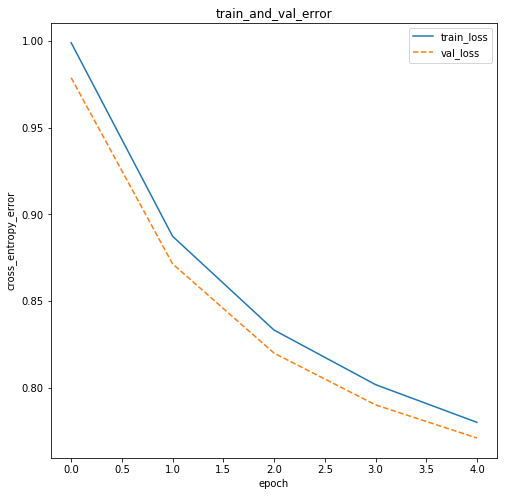

In [23]:
plt.figure(figsize=(8, 8))
plt.plot(two_d_cnn.losses, '-', label='train_loss')
plt.plot(two_d_cnn.val_losses, '--', label='val_loss')
plt.title('train_and_val_error')
plt.xlabel('epoch')
plt.ylabel('cross_entropy_error')
plt.legend()
plt.show()

In [24]:
two_d_cnn.predict(X_test)

array([7, 3, 1, ..., 4, 5, 6], dtype=int64)

In [25]:
two_d_cnn.accuracy(X_test, y_test)

0.7501

【問題9】出力サイズとパラメータ数の計算

入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし

フィルターの縦 * フィルターの横 * 入力のチャンネル数 * 出力のチャンネル数 + バイアス(1チャンネルごとに1つ)

3×3×3×6+6=60

入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし

3×3×24×48+48=10416

入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし

3×3×10×20+20=1820